In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional, RepeatVector, TimeDistributed, ConvLSTM2D
from sklearn.preprocessing import MinMaxScaler
import time

In [2]:
df = pd.read_csv('output2.csv',usecols=[1]).clip(0)

In [3]:
df.head()

,Plasma_current
0,0.0000
1,1.3591
2,5.7585
3,11.6940
4,17.8730


In [4]:
df.size

401000

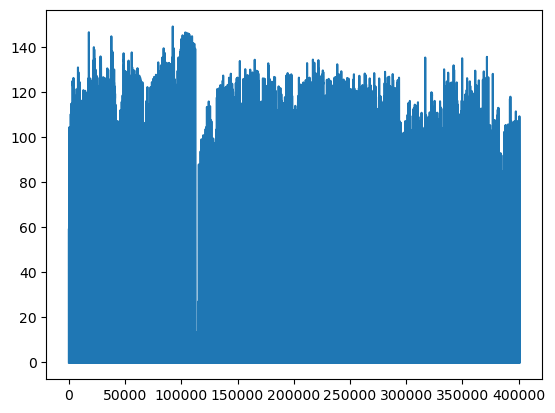

In [5]:
plt.plot(df)

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(df)

In [7]:
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
test.shape

(80200, 1)

In [8]:
def to_sequences(dataset, time_window,output):
    x = []
    y = []

    for i in range(len(dataset)-time_window-1-output):
        #print(i)
        window = dataset[i:(i+time_window), 0]
        x.append(window)
        y.append(dataset[i+time_window:i+time_window+output, 0])

    return np.array(x),np.array(y)

In [9]:
time_window = 10
output=20 # Number of time steps to look back
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, time_window, output)
testX, testY = to_sequences(test, time_window,output)

In [10]:
trainY.shape

(320769, 20)

In [11]:
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
print(trainX.shape)
testX = testX.reshape((testX.shape[0], testX.shape[1], 1))
print(testX.shape)
trainY = trainY.reshape((trainY.shape[0], trainY.shape[1], 1))
print(trainY.shape)
testY= testY.reshape((testY.shape[0], testY.shape[1], 1))
print(testY.shape)

(320769, 10, 1)
(80169, 10, 1)
(320769, 20, 1)
(80169, 20, 1)


In [12]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Model

In [13]:
model = Sequential()
# keras.Input
# model.add(LSTM(10, activation='relu',return_sequences=True,input_shape=(time_window,1)))
# model.add(Bidirectional(LSTM(10, activation='relu',input_shape=(time_window,1))))
# model.add(RepeatVector(output))
# model.add(LSTM(10, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(1,activation='relu')))

input_layer = Input(shape=(10,1))
x = Bidirectional(LSTM(100, activation='relu'))(input_layer)
x = RepeatVector(output)(x)
x = LSTM(100, activation='relu', return_sequences=True)(x)
x = TimeDistributed(Dense(1,activation='relu'))(x)

model = Model(inputs=input_layer, outputs=x)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 10, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 200)                 │          81,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 20, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20, 100)             │         120,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 20, 1)               │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 202,101 (789.46 KB)

 Trainable params: 202,101 (789.46 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(loss='mse', optimizer='adam')

In [15]:
callback = [keras.callbacks.EarlyStopping(monitor='loss',patience=3)]

In [16]:
model.fit(trainX, trainY, epochs=20, batch_size=32,validation_data=(testX,testY),callbacks=callback)

Epoch 1/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 341s 33ms/step - loss: 0.0100 - val_loss: 0.0056
Epoch 2/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 328s 33ms/step - loss: 0.0191 - val_loss: 0.0056
Epoch 3/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 324s 32ms/step - loss: 0.0066 - val_loss: 0.0055
Epoch 4/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 329s 33ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 5/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 329s 33ms/step - loss: 0.0064 - val_loss: 0.0055
Epoch 6/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 345s 34ms/step - loss: 0.0064 - val_loss: 0.0054
Epoch 7/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 337s 34ms/step - loss: 0.0063 - val_loss: 0.0053
Epoch 8/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 340s 34ms/step - loss: 0.0063 - val_loss: 0.0055
Epoch 9/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 398s 36ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 10/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 379s 35ms/step - loss: 0.0062 - val_loss: 0.0054
Epoch 11/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 378s 35ms/step - loss: 0

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

10025/10025 ━━━━━━━━━━━━━━━━━━━━ 109s 11ms/step
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step


In [ ]:
trainPredict.shape

In [ ]:
trainY.shape

In [ ]:
trainPredict = trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[1])
testPredict = testPredict.reshape(testPredict.shape[0],testPredict.shape[1])

In [ ]:
trainY = trainY.reshape(trainY.shape[0],trainY.shape[1])
testY = testY.reshape(testY.shape[0],testY.shape[1])

In [ ]:
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
trainY = scaler.inverse_transform(trainY)
testY = scaler.inverse_transform(testY)

In [ ]:
from sklearn.metrics import mean_squared_error as mse
import math

In [ ]:
train_RMSE = math.sqrt(mse(trainPredict,trainY))
test_RMSE = math.sqrt(mse(testPredict,testY))

In [ ]:
train_RMSE

In [ ]:
test_RMSE

In [ ]:
trainY[:2]

In [ ]:
trainPredict[:2]

In [ ]:
plt.plot(testY[400:800,19],color='r')
plt.plot(testPredict[400:800,19])

In [ ]:
x_test = np.array([0.067932,0.23938,3.3028,5.7289,13.299,19.154,23.278,29.618,32.772,34.746])
x_test = x_test.reshape((-1, 5,1))
print(x_test.shape)

In [ ]:
yhat = model.predict(x_test)

In [ ]:
yhat